In [ ]:
# NLTK ইনস্টল (একবারই চালাতে হবে)
!pip install --quiet nltk


In [ ]:
# লাইব্রেরি ইম্পোর্ট
import pandas as pd
import numpy as np
import zipfile
import re
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegressionCV
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer

# NLTK ডাটা ডাউনলোড
nltk.download('stopwords')
nltk.download('wordnet')


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...


True

In [ ]:
from google.colab import files

# news.zip ফাইল আপলোড করো
uploaded = files.upload()


Saving news.zip to news.zip


In [ ]:
# আপলোডকৃত ফাইল আনজিপ
with zipfile.ZipFile("news.zip", 'r') as zip_ref:
    zip_ref.extractall("unzipped_news")


In [ ]:
# CSV ফাইল লোড
true_df = pd.read_csv("unzipped_news/True.csv")
fake_df = pd.read_csv("unzipped_news/Fake.csv")

# লেবেল যোগ
true_df['label'] = 1
fake_df['label'] = 0

# মার্জ
combined_df = pd.concat([true_df, fake_df], ignore_index=True)

# ডুপ্লিকেট এবং null রো বাদ
combined_df.drop_duplicates(inplace=True)
combined_df.dropna(inplace=True)

print(f"Combined data shape: {combined_df.shape}")


Combined data shape: (44689, 5)


In [ ]:
stop_words = set(stopwords.words('english'))
lemmatizer = WordNetLemmatizer()

def clean_text(text):
    text = text.lower()
    text = re.sub(r'<.*?>', ' ', text)
    text = re.sub(r'http\S+', ' ', text)
    text = re.sub(r'[^a-z ]', ' ', text)
    text = re.sub(r'\s+', ' ', text)
    words = text.split()
    words = [w for w in words if w not in stop_words]
    words = [lemmatizer.lemmatize(w) for w in words]
    return ' '.join(words)

combined_df['clean_text'] = combined_df['text'].apply(clean_text)

print(combined_df[['text', 'clean_text']].head())


                                                text  \
0  WASHINGTON (Reuters) - The head of a conservat...   
1  WASHINGTON (Reuters) - Transgender people will...   
2  WASHINGTON (Reuters) - The special counsel inv...   
3  WASHINGTON (Reuters) - Trump campaign adviser ...   
4  SEATTLE/WASHINGTON (Reuters) - President Donal...   

                                          clean_text  
0  washington reuters head conservative republica...  
1  washington reuters transgender people allowed ...  
2  washington reuters special counsel investigati...  
3  washington reuters trump campaign adviser geor...  
4  seattle washington reuters president donald tr...  


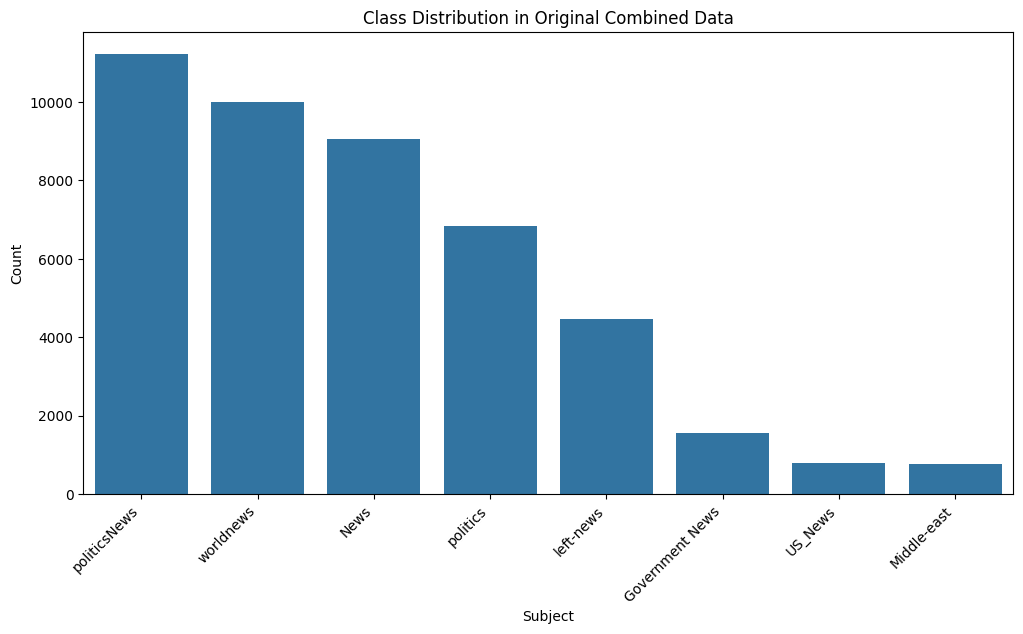

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(12,6))
sns.countplot(data=combined_df, x='subject', order=combined_df['subject'].value_counts().index)
plt.xticks(rotation=45, ha='right')
plt.title('Class Distribution in Original Combined Data')
plt.xlabel('Subject')
plt.ylabel('Count')
plt.show()

/tmp/ipython-input-1263712882.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=combined_df, x='label', palette=['red','green'])


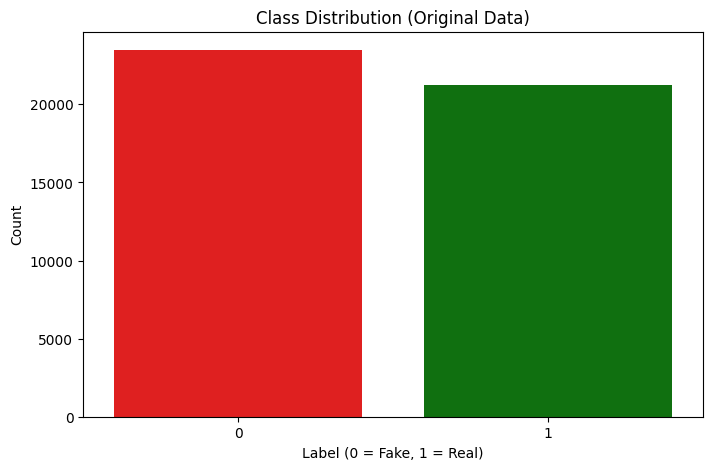

In [ ]:
plt.figure(figsize=(8,5))
sns.countplot(data=combined_df, x='label', palette=['red','green'])
plt.title('Class Distribution (Original Data)')
plt.xlabel('Label (0 = Fake, 1 = Real)')
plt.ylabel('Count')
plt.show()


In [ ]:
# প্রতিটি সাবজেক্ট থেকে 1000 নমুনা নিন (রিপ্লেসমেন্ট সহ)
balanced_df = combined_df.groupby('subject').sample(n=1000, replace=True, random_state=123).reset_index(drop=True)

# label আপডেট (politicsNews ও worldnews = 1, বাকি = 0)
real_classes = ['politicsNews', 'worldnews']
balanced_df['label'] = balanced_df['subject'].apply(lambda x: 1 if x in real_classes else 0)

print(balanced_df['label'].value_counts())


label
0    6000
1    2000
Name: count, dtype: int64


/tmp/ipython-input-480580143.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=balanced_df, x='subject', order=balanced_df['subject'].value_counts().index, palette='Set2')


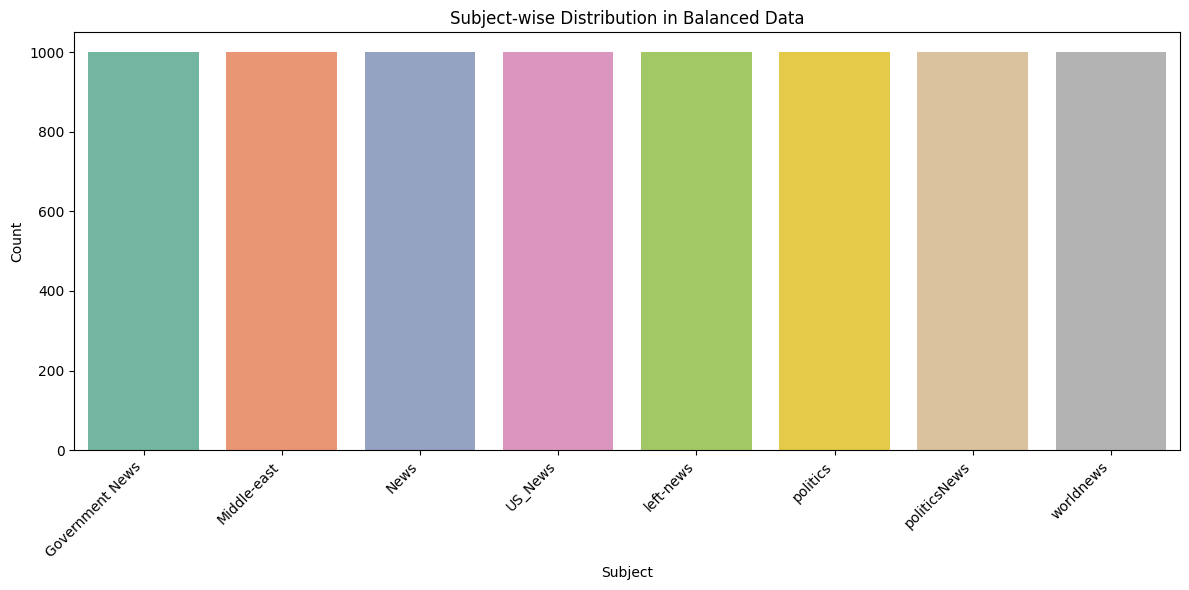

In [ ]:
plt.figure(figsize=(12,6))
sns.countplot(data=balanced_df, x='subject', order=balanced_df['subject'].value_counts().index, palette='Set2')
plt.xticks(rotation=45, ha='right')
plt.title('Subject-wise Distribution in Balanced Data')
plt.xlabel('Subject')
plt.ylabel('Count')
plt.tight_layout()
plt.show()


In [ ]:
import pandas as pd

# balanced_df এর label distribution চেক
print(balanced_df['label'].value_counts())

# মাইনরিটি ক্লাসের সংখ্যা বের করা
min_count = balanced_df['label'].value_counts().min()

# লেবেল অনুযায়ী আলাদা ডেটাফ্রেম
df_class_0 = balanced_df[balanced_df['label'] == 0]
df_class_1 = balanced_df[balanced_df['label'] == 1]

# র‍্যান্ডম সিড সেট
random_state = 42

# আন্ডারস্যাম্পলিং করে দুই ক্লাসকে সমান করা
if len(df_class_0) > len(df_class_1):
    df_class_0_under = df_class_0.sample(min_count, random_state=random_state)
    balanced_label_df = pd.concat([df_class_0_under, df_class_1], axis=0).sample(frac=1, random_state=random_state).reset_index(drop=True)
elif len(df_class_1) > len(df_class_0):
    df_class_1_under = df_class_1.sample(min_count, random_state=random_state)
    balanced_label_df = pd.concat([df_class_0, df_class_1_under], axis=0).sample(frac=1, random_state=random_state).reset_index(drop=True)
else:
    balanced_label_df = balanced_df.sample(frac=1, random_state=random_state).reset_index(drop=True)

# ব্যালান্সড ডেটাফ্রেমের লেবেল ডিস্ট্রিবিউশন দেখাও
print(balanced_label_df['label'].value_counts())


label
0    6000
1    2000
Name: count, dtype: int64
label
0    2000
1    2000
Name: count, dtype: int64


/tmp/ipython-input-1568602242.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=balanced_label_df, x='label', palette=['red', 'green'])


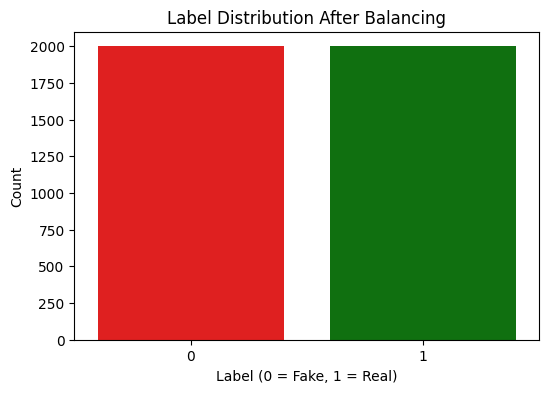

In [ ]:
# লেবেল distribution plot
plt.figure(figsize=(6,4))
sns.countplot(data=balanced_label_df, x='label', palette=['red', 'green'])
plt.title('Label Distribution After Balancing')
plt.xlabel('Label (0 = Fake, 1 = Real)')
plt.ylabel('Count')
plt.show()

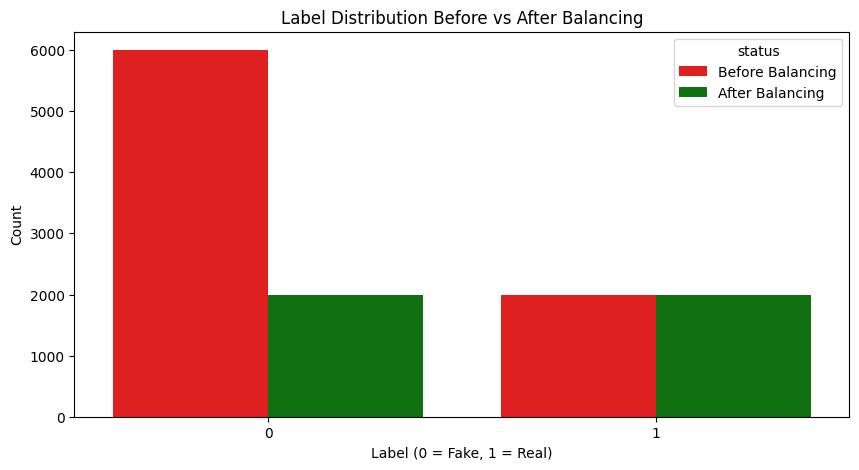

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# ধরো balanced_df হলো before balancing ডেটা
# আর balanced_label_df হলো after balancing ডেটা

# দুই ডেটাতে একটি নতুন কলাম যোগ করা হলো
before_df = balanced_df.copy()
before_df['status'] = 'Before Balancing'

after_df = balanced_label_df.copy()
after_df['status'] = 'After Balancing'

# দুই ডেটা একসাথে যোগ করা হলো
compare_df = pd.concat([before_df, after_df], axis=0)

plt.figure(figsize=(10,5))
sns.countplot(data=compare_df, x='label', hue='status', palette=['red','green'])
plt.title('Label Distribution Before vs After Balancing')
plt.xlabel('Label (0 = Fake, 1 = Real)')
plt.ylabel('Count')
plt.show()


In [ ]:
print(balanced_df.shape)   # Python


(8000, 6)


In [ ]:
from sklearn.model_selection import train_test_split

# Stratified 80-20 split on balanced_label_df
X_train, X_test, y_train, y_test = train_test_split(
    balanced_label_df['clean_text'],
    balanced_label_df['label'],
    test_size=0.2,
    random_state=42,
    stratify=balanced_label_df['label']
)

# Train ও Test সাইজ দেখানো
print("Train size:", X_train.shape[0], ", Test size:", X_test.shape[0])


Train size: 3200 , Test size: 800


In [ ]:
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer
from nltk.corpus import stopwords

# 1. টোকেনাইজার বা stopwords লিস্ট
stop_words = set(stopwords.words('english'))

# 2. CountVectorizer দিয়ে ভোকাবুলারি তৈরি (min_df=5, max_df=0.9)
# Convert the set of stop words to a list
count_vect = CountVectorizer(min_df=5, max_df=0.9, stop_words=list(stop_words))

# 3. train data থেকে ফিচার ম্যাট্রিক্স তৈরি
X_train_counts = count_vect.fit_transform(X_train)

# 4. TF-IDF ট্রান্সফর্মার ফিট ও ট্রান্সফর্ম
tfidf_transformer = TfidfTransformer()
X_train_tfidf = tfidf_transformer.fit_transform(X_train_counts)

# 5. Test data শুধু transform করো
X_test_counts = count_vect.transform(X_test)
X_test_tfidf = tfidf_transformer.transform(X_test_counts)

# shape check
print("Train TF-IDF Shape:", X_train_tfidf.shape)
print("Test TF-IDF Shape:", X_test_tfidf.shape)

Train TF-IDF Shape: (3200, 11201)
Test TF-IDF Shape: (800, 11201)


In [ ]:
import numpy as np
from collections import Counter
import re

# ১. TF-IDF ম্যাট্রিক্সের কিছু মান দেখা (sparse matrix slice)
print("TF-IDF matrix slice (first 3 docs, first 5 terms):")
print(X_train_tfidf[:3, :5].toarray())

# ২. TF-IDF স্কোরের সারমর্ম দেখা (non-zero values summary)
tfidf_data = X_train_tfidf.data  # non-zero TF-IDF values
print("\nTF-IDF values summary:")
print(f"Count: {len(tfidf_data)}")
print(f"Min: {np.min(tfidf_data):.6f}")
print(f"Max: {np.max(tfidf_data):.6f}")
print(f"Mean: {np.mean(tfidf_data):.6f}")
print(f"Median: {np.median(tfidf_data):.6f}")

# ৩. ভোকাবুলারির টপ টার্মস (term frequency অনুসারে)

# Tokenizer (lowercase words only)
def tokenize(text):
    return re.findall(r'\b\w+\b', text.lower())

# Train texts tokenization
train_tokens = []
for doc in X_train:
    train_tokens.extend(tokenize(doc))

# Term frequency গণনা
term_freq = Counter(train_tokens)

# টপ ১০ টার্ম প্রিন্ট
print("\nTop 10 terms by frequency:")
print(term_freq.most_common(10))


TF-IDF matrix slice (first 3 docs, first 5 terms):
[[0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.]]

TF-IDF values summary:
Count: 518523
Min: 0.001645
Max: 0.936655
Mean: 0.056753
Median: 0.042330

Top 10 terms by frequency:
[('said', 9604), ('trump', 8005), ('u', 6551), ('state', 4755), ('president', 4106), ('would', 3947), ('year', 3350), ('one', 2987), ('people', 2903), ('also', 2613)]


Training Logistic Regression ...
Logistic Regression training done.

Training Random Forest ...
Random Forest training done.

Training XGBoost ...


/usr/local/lib/python3.11/dist-packages/xgboost/training.py:183: UserWarning: [22:02:17] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


XGBoost training done.

Training AdaBoost ...
AdaBoost training done.

Training Stacking Ensemble ...


/usr/local/lib/python3.11/dist-packages/xgboost/training.py:183: UserWarning: [22:02:37] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/usr/local/lib/python3.11/dist-packages/xgboost/training.py:183: UserWarning: [22:02:56] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/usr/local/lib/python3.11/dist-packages/xgboost/training.py:183: UserWarning: [22:03:00] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/usr/local/lib/python3.11/dist-packages/xgboost/training.py:183: UserWarning: [22:03:07] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/usr/local/lib/python3.11/dist-packages/xgboost/training.py:183: UserWarning: [22:03:11] WARNING: /w

Stacking Ensemble training done.

--- Logistic Regression ---
Accuracy: 0.97875
Classification Report:
               precision    recall  f1-score   support

           0       0.98      0.97      0.98       400
           1       0.98      0.98      0.98       400

    accuracy                           0.98       800
   macro avg       0.98      0.98      0.98       800
weighted avg       0.98      0.98      0.98       800



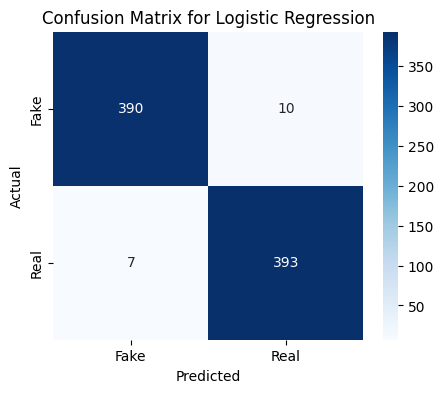

--- Random Forest ---
Accuracy: 0.9925
Classification Report:
               precision    recall  f1-score   support

           0       1.00      0.99      0.99       400
           1       0.99      1.00      0.99       400

    accuracy                           0.99       800
   macro avg       0.99      0.99      0.99       800
weighted avg       0.99      0.99      0.99       800



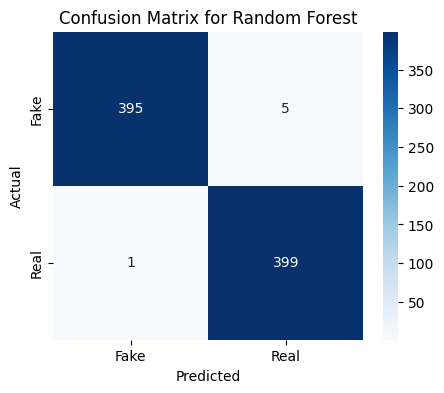

--- XGBoost ---
Accuracy: 0.99625
Classification Report:
               precision    recall  f1-score   support

           0       1.00      0.99      1.00       400
           1       0.99      1.00      1.00       400

    accuracy                           1.00       800
   macro avg       1.00      1.00      1.00       800
weighted avg       1.00      1.00      1.00       800



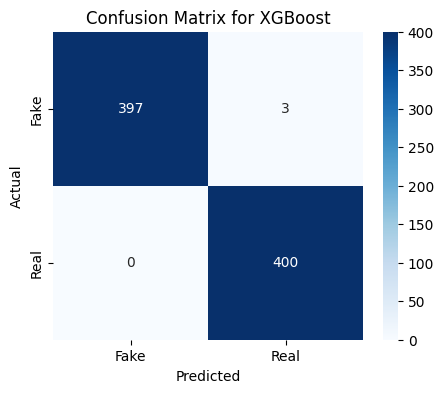

--- AdaBoost ---
Accuracy: 0.99625
Classification Report:
               precision    recall  f1-score   support

           0       1.00      0.99      1.00       400
           1       0.99      1.00      1.00       400

    accuracy                           1.00       800
   macro avg       1.00      1.00      1.00       800
weighted avg       1.00      1.00      1.00       800



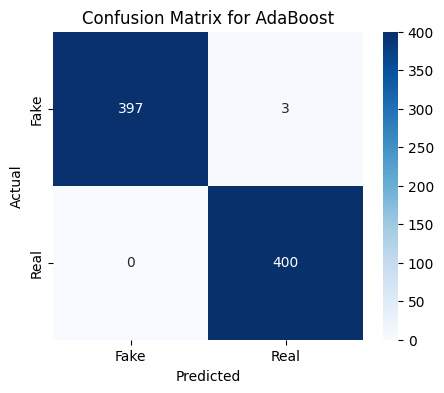

--- Stacking Ensemble ---
Accuracy: 0.9975
Classification Report:
               precision    recall  f1-score   support

           0       1.00      0.99      1.00       400
           1       1.00      1.00      1.00       400

    accuracy                           1.00       800
   macro avg       1.00      1.00      1.00       800
weighted avg       1.00      1.00      1.00       800



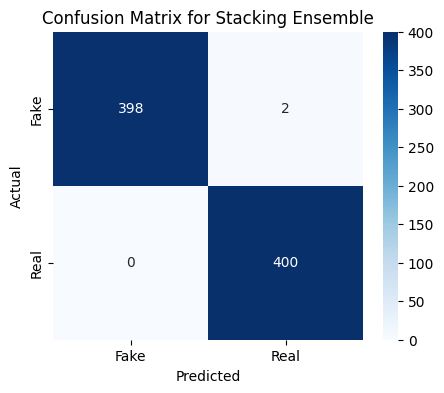

In [ ]:
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, StackingClassifier
from xgboost import XGBClassifier

# মডেল ডিফাইন
lr_model = LogisticRegression(max_iter=1000, random_state=42)
rf_model = RandomForestClassifier(n_estimators=100, random_state=42)
xgb_model = XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42)
ada_model = AdaBoostClassifier(n_estimators=100, random_state=42)

estimators = [
    ('lr', lr_model),
    ('rf', rf_model),
    ('xgb', xgb_model)
]

stack_model = StackingClassifier(estimators=estimators, final_estimator=LogisticRegression(), cv=5)

# মডেল লিস্টে রাখা (Stacking আলাদাভাবে)
models = {
    "Logistic Regression": lr_model,
    "Random Forest": rf_model,
    "XGBoost": xgb_model,
    "AdaBoost": ada_model,
    "Stacking Ensemble": stack_model
}

# মডেল ট্রেন ও প্রেডিক্ট
predictions = {}
for name, model in models.items():
    print(f"Training {name} ...")
    model.fit(X_train_tfidf, y_train)
    preds = model.predict(X_test_tfidf)
    predictions[name] = preds
    print(f"{name} training done.\n")

# প্রেডিকশন এখন predictions ডিকশনারিতে আছে
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

def evaluate_model(y_true, y_pred, model_name):
    print(f"--- {model_name} ---")
    print("Accuracy:", accuracy_score(y_true, y_pred))
    print("Classification Report:\n", classification_report(y_true, y_pred))
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(5,4))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=['Fake', 'Real'], yticklabels=['Fake', 'Real'])
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.title(f'Confusion Matrix for {model_name}')
    plt.show()

for model_name, preds in predictions.items():
    evaluate_model(y_test, preds, model_name)


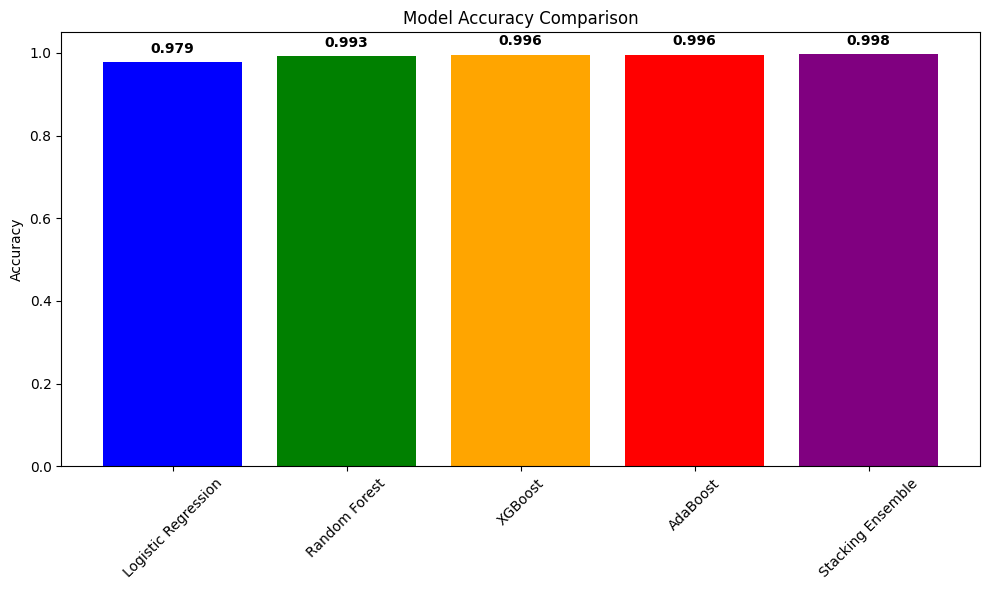

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

# Calculate accuracies from the predictions dictionary
accuracies = {name: accuracy_score(y_test, preds) for name, preds in predictions.items()}

plt.figure(figsize=(10,6))  # চিত্রটা একটু বড় করলাম
bars = plt.bar(accuracies.keys(), accuracies.values(), color=['blue', 'green', 'orange', 'red', 'purple'])
plt.title('Model Accuracy Comparison')
plt.ylabel('Accuracy')
plt.ylim(0, 1.05)  # একটু বেশি রেখেছি যেন label জায়গা পায়
plt.xticks(rotation=45)

# প্রতিটি বারের উপরে text দেখানো (একটু উপরে সরিয়ে দেওয়া হয়েছে)
for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width() / 2.0, height + 0.015, f'{height:.3f}',
             ha='center', va='bottom', fontsize=10, fontweight='bold')

plt.tight_layout()
plt.show()

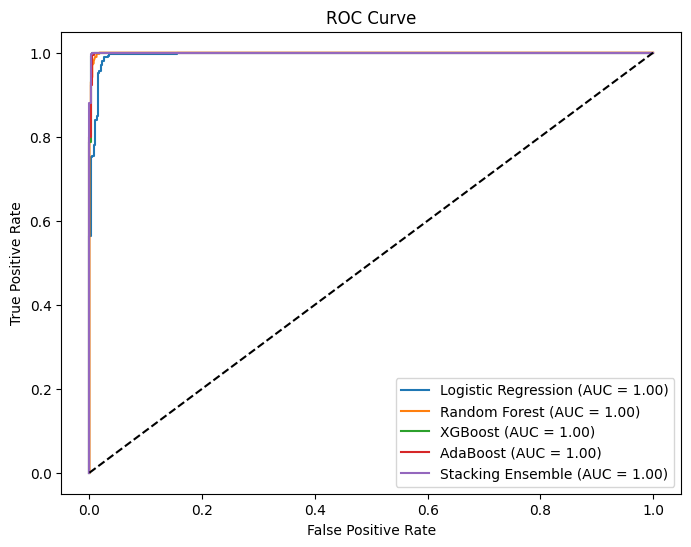

In [ ]:
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt

plt.figure(figsize=(8,6))

for model_name, preds in predictions.items():
    if hasattr(models[model_name], "predict_proba"):
        probs = models[model_name].predict_proba(X_test_tfidf)[:,1]
        fpr, tpr, _ = roc_curve(y_test, probs)
        roc_auc = auc(fpr, tpr)
        plt.plot(fpr, tpr, label=f'{model_name} (AUC = {roc_auc:.2f})')

plt.plot([0,1], [0,1], 'k--')  # diagonal line
plt.title('ROC Curve')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc='lower right')
plt.show()
